# scratch work

In [49]:
import jax

jax.config.update("jax_enable_x64", True)
import sqlite3

import astropy.units as u
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroquery.jplhorizons import Horizons
from numpy.polynomial import chebyshev
from tqdm import tqdm

from jorbit import Particle
from jorbit.astrometry.sky_projection import sky_sep
# from jorbit.utils.horizons import get_observer_positions


In [2]:
t0 = Time("2020-01-01")
forward_times = t0 + jnp.arange(0, 20.001, 1*u.hour.to(u.year))*u.year
reverse_times = t0 - jnp.arange(0, 20.001, 1*u.hour.to(u.year))*u.year

forward_pos = jnp.load("forward_pos.npy")
reverse_pos = jnp.load("reverse_pos.npy")

In [15]:
# @jax.jit
def eval_cheby(coefficients, x):
    b_ii = jnp.zeros(2)
    b_i = jnp.zeros(2)

    def scan_func(X, a):
        b_i, b_ii = X
        tmp = b_i
        b_i = a + 2 * x * b_i - b_ii
        b_ii = tmp
        return (b_i, b_ii), b_i

    (b_i, b_ii), s = jax.lax.scan(scan_func, (b_i, b_ii), coefficients[:-1])
    return coefficients[-1] + x * b_i - b_ii, s

# @jax.jit
def _individual_state(init, intlen, coeffs, tdb):
    tdb2 = 0.0  # leaving in case we ever decide to increase the time precision and use 2 floats
    _, _, n = coeffs.shape

    # 2451545.0 is the J2000 epoch in TDB
    index1, offset1 = jnp.divmod((tdb - 2451545.0) * 86400.0 - init, intlen)
    index2, offset2 = jnp.divmod(tdb2 * 86400.0, intlen)
    index3, offset = jnp.divmod(offset1 + offset2, intlen)
    index = (index1 + index2 + index3).astype(int)

    omegas = index == n
    index = jnp.where(omegas, index - 1, index)
    offset = jnp.where(omegas, offset + intlen, offset)

    coefficients = coeffs[:, :, index]

    s = 2.0 * offset / intlen - 1.0

    (approx_ra, approx_dec), _ = eval_cheby(coefficients, s)  # in km here
    return approx_ra % (2*jnp.pi), approx_dec


In [55]:
t0 = Time("2020-01-01")
forward_times = t0 + jnp.arange(0, 20.001, 10*u.hour.to(u.year))*u.year
reverse_times = t0 - jnp.arange(0, 20.001, 10*u.hour.to(u.year))*u.year

forward_pos = jnp.load("forward_pos.npy")
reverse_pos = jnp.load("reverse_pos.npy")

In [56]:
forward_pos.shape


(17533, 3)

In [7]:
def generate_ephem(particle_name, chunk_size, degree):
    # chunk size in days

    obj = Horizons(id=particle_name, location="500@0", epochs=t0.tdb.jd)
    vecs = obj.vectors(refplane="earth")
    x0 = jnp.array([vecs["x"], vecs["y"], vecs["z"]]).T[0]
    v0 = jnp.array([vecs["vx"], vecs["vy"], vecs["vz"]]).T[0]
    particle = Particle(x=x0, v=v0, time=t0, gravity="newtonian solar system")

    t = forward_times.tdb.jd

    eph = particle.ephemeris(t, observer=forward_pos)

    r = jnp.unwrap(eph.ra.rad)
    d = eph.dec.rad

    num_chunks = int(jnp.ceil((t[-1] - t[0]) / chunk_size))

    init = (t[0] - 2451545.0) * 86400.0
    intlen = chunk_size * 86400.0

    coeffs = jnp.zeros((degree + 1, 2, num_chunks))
    for i in range(num_chunks):
        inds = (t >= t[0] + i * chunk_size) & (t < t[0] + (i + 1) * chunk_size)
        t_chunk = t[inds]
        r_chunk = r[inds]
        d_chunk = d[inds]

        # Scale time to [-1, 1] domain
        t_min, t_max = t0.tdb.jd + i * chunk_size, t0.tdb.jd + (i + 1) * chunk_size
        t_scaled = 2 * (t_chunk - t_min) / (t_max - t_min) - 1

        # Fit Chebyshev polynomials
        coefficients = chebyshev.chebfit(t_scaled, r_chunk, degree)
        coefficients = coefficients[::-1]
        coeffs = coeffs.at[:, 0, i].set(coefficients)

        coefficients = chebyshev.chebfit(t_scaled, d_chunk, degree)
        coefficients = coefficients[::-1]
        coeffs = coeffs.at[:, 1, i].set(coefficients)

    return init, intlen, coeffs



def test_ephem(particle_name, ephem, t):
    obj = Horizons(id=particle_name, location="500@399", epochs=t.utc.jd, id_type="smallbody")
    coord = obj.ephemerides(quantities=1, extra_precision=True)
    s = SkyCoord(coord["RA"], coord["DEC"], unit=(u.deg, u.deg))

    ra, dec = _individual_state(*ephem, t.tdb.jd)

    return sky_sep(ra, dec, s.ra.rad, s.dec.rad)


In [45]:
q = generate_ephem("737779", 10, 30, 10)

In [46]:
errs = []
for _i in tqdm(range(100)):
    delta = np.random.uniform(0, 20)
    t_test = t0 + delta * u.year
    err = test_ephem("737779", q, t0+delta*u.year)
    if err > 1.0:
        print(delta)
    errs.append(err)


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


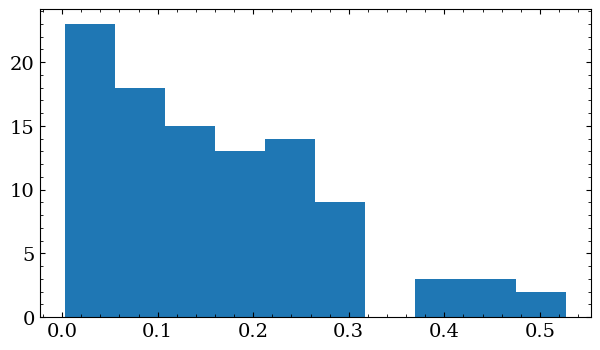

In [35]:
errs = jnp.array(errs)
plt.hist(errs);

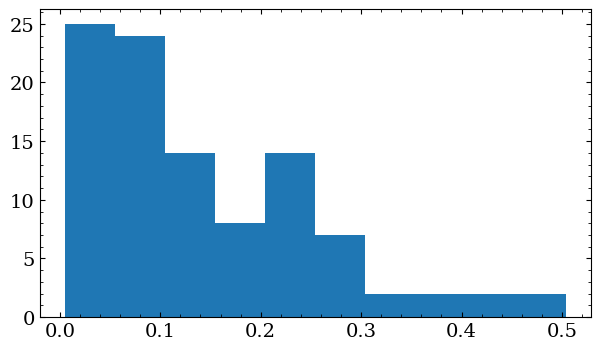

In [30]:
errs = jnp.array(errs)
plt.hist(errs);

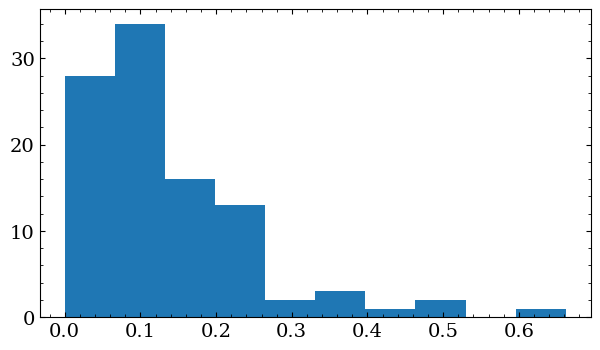

In [27]:
errs = jnp.array(errs)
plt.hist(errs);

In [42]:
with open("MPCORB.DAT") as f:
    lines = f.readlines()
lines[43].split()[0]

'00001'

In [47]:
def mpc_code_to_number(code):

    def base62_to_decimal(char):
        """
        Convert a single base-62 character to its decimal value.
        Base-62 uses:
        - 0-9 for values 0-9
        - A-Z for values 10-35
        - a-z for values 36-61
        """
        if char.isdigit():
            return int(char)
        elif char.isupper():
            return ord(char) - ord('A') + 10
        else:
            return ord(char) - ord('a') + 36

    # if it's unnumbered, just return the code
    if len(code) == 7:
        return code

    # if it's numbered, now it should only be 5 characters long
    assert len(code) == 5

    # low numbers are just numbers
    if "~" not in code:
        return code

    # higher ones start with a tilde and are base 62
    assert code[0] == "~"

    base62_part = code[1:]

    total = 0
    for position, char in enumerate(reversed(base62_part)):
        decimal_value = base62_to_decimal(char)
        total += decimal_value * (62 ** position)

    # Add back the offset of 620,000
    final_number = total + 620000

    return final_number

mpc_code_to_number("~0Udk")

737784

In [54]:
# First, we need to create our database and table
def setup_database():
    with sqlite3.connect('ephem_results.db') as conn:
        # Enable Write-Ahead Logging for better concurrent access
        conn.execute('PRAGMA journal_mode=WAL')

        # Create our table if it doesn't exist
        conn.execute('''
            CREATE TABLE IF NOT EXISTS results (
                input_name TEXT PRIMARY KEY,
                output_vector BLOB
            )
        ''')

# Helper function to convert numpy array to binary for storage
def adapt_array(arr):
    """Convert numpy array to binary for SQLite storage"""
    return arr.tobytes()

# Helper function to convert binary back to numpy array
def convert_array(blob):
    """Convert binary blob back to numpy array"""
    return np.frombuffer(blob)

# Function to write a single result
def write_result(input_name, output_vector):
    with sqlite3.connect('model_results.db') as conn:
        # Convert the numpy array to binary
        vector_binary = adapt_array(output_vector)

        # Insert the result
        conn.execute(
            'INSERT OR REPLACE INTO results (input_name, output_vector) VALUES (?, ?)',
            (input_name, vector_binary)
        )

In [48]:
def contribute_to_ephem(line_start, line_stop):
    with open("MPCORB.DAT") as f:
        lines = f.readlines()[line_start:line_stop+1]
    targets = [line.split()[0] for line in lines]
    targets = [mpc_code_to_number(target) for target in targets]

    setup_database()

    for target in targets:
        _, _, coeffs = generate_ephem(particle_name=target, chunk_size=30, degree=10)
        write_result(target, coeffs)

    return targets

# contribute_to_ephem(43, 100)
contribute_to_ephem(659397, 659399)

[659355, 659356, 659357]

In [32]:
import os

os.path.getsize("MPCORB.DAT") / 1e6

291.512178

In [31]:
40*u.year.to(u.week)

2087.1428571428573

In [51]:
from astropy.utils.data import download_file

download_file("https://zenodo.org/records/10161743/files/ERS_DataSynthesis_Zenodo.zip?download=1", cache=True)

'/Users/cassese/.astropy/cache/download/url/d130157051acdb2edae869c7ca04e3e8/contents'

In [41]:
from glob import glob

glob("/Users/cassese/.astropy/cache/download/url/d130157051acdb2edae869c7ca04e3e8/contents/*")

[]

In [42]:
import zipfile

with zipfile.ZipFile("/Users/cassese/.astropy/cache/download/url/d130157051acdb2edae869c7ca04e3e8/contents", 'r') as zip_ref:
    # Extract all contents
    zip_ref.extractall("/Users/cassese/.astropy/cache/download/url/d130157051acdb2edae869c7ca04e3e8/")

In [1]:
# import jax

# jax.config.update("jax_enable_x64", True)

# import astropy.units as u
# import jax.numpy as jnp
# import numpy as np
# from astropy.time import Time
# from tqdm import tqdm


# def generate_ephem(particle_name, chunk_size, degree):
#     # chunk size in days
#     print(f"beginning for {particle_name}")
#     obj = Horizons(id=particle_name, location="500@0", epochs=t0.tdb.jd, id_type="smallbody")
#     vecs = obj.vectors(refplane="earth")
#     print("horizons vectors acquired")
#     x0 = jnp.array([vecs["x"], vecs["y"], vecs["z"]]).T[0]
#     v0 = jnp.array([vecs["vx"], vecs["vy"], vecs["vz"]]).T[0]
#     print("creating particle")
#     particle = Particle(x=x0, v=v0, time=t0, gravity="newtonian solar system")

#     t = forward_times.tdb.jd

#     print("generating ephemeris")
#     eph = particle.ephemeris(t, observer=forward_pos)

#     print("forming coefficients")
#     r = jnp.unwrap(eph.ra.rad)
#     d = eph.dec.rad

#     num_chunks = int(jnp.ceil((t[-1] - t[0]) / chunk_size))

#     init = (t[0] - 2451545.0) * 86400.0
#     intlen = chunk_size * 86400.0

#     coeffs = jnp.zeros((degree + 1, 2, num_chunks))
#     for i in range(num_chunks):
#         inds = (t >= t[0] + i * chunk_size) & (t < t[0] + (i + 1) * chunk_size)
#         t_chunk = t[inds]
#         r_chunk = r[inds]
#         d_chunk = d[inds]

#         # Scale time to [-1, 1] domain
#         t_min, t_max = t0.tdb.jd + i * chunk_size, t0.tdb.jd + (i + 1) * chunk_size
#         t_scaled = 2 * (t_chunk - t_min) / (t_max - t_min) - 1

#         # Fit Chebyshev polynomials
#         coefficients = chebyshev.chebfit(t_scaled, r_chunk, degree)
#         coefficients = coefficients[::-1]
#         coeffs = coeffs.at[:, 0, i].set(coefficients)

#         coefficients = chebyshev.chebfit(t_scaled, d_chunk, degree)
#         coefficients = coefficients[::-1]
#         coeffs = coeffs.at[:, 1, i].set(coefficients)

#     return (init, intlen, coeffs), x0, v0


# # def test_ephem(particle_name, ephem, t):
# #     obj = Horizons(id=particle_name, location="500@399", epochs=t.utc.jd, id_type="smallbody")
# #     coord = obj.ephemerides(quantities=1, extra_precision=True)
# #     s = SkyCoord(coord["RA"], coord["DEC"], unit=(u.deg, u.deg))

# #     ra, dec = _individual_state(*ephem, t.tdb.jd)

# #     return sky_sep(ra, dec, s.ra.rad, s.dec.rad)


# def mpc_code_to_number(code):

#     def base62_to_decimal(char):
#         """
#         Convert a single base-62 character to its decimal value.
#         Base-62 uses:
#         - 0-9 for values 0-9
#         - A-Z for values 10-35
#         - a-z for values 36-61
#         """
#         if char.isdigit():
#             return int(char)
#         elif char.isupper():
#             return ord(char) - ord("A") + 10
#         else:
#             return ord(char) - ord("a") + 36

#     # if it's unnumbered, just return the code
#     if len(code) == 7:
#         return code

#     # if it's numbered, now it should only be 5 characters long
#     assert len(code) == 5

#     # low numbers are just numbers
#     if "~" not in code:
#         return code

#     # higher ones start with a tilde and are base 62
#     assert code[0] == "~"

#     base62_part = code[1:]

#     total = 0
#     for position, char in enumerate(reversed(base62_part)):
#         decimal_value = base62_to_decimal(char)
#         total += decimal_value * (62**position)

#     # Add back the offset of 620,000
#     final_number = total + 620000

#     return final_number


# def setup_database():
#     with sqlite3.connect("ephem_results.db") as conn:
#         conn.execute("PRAGMA journal_mode=WAL")

#         # Create our table if it doesn't exist
#         conn.execute(
#             """
#             CREATE TABLE IF NOT EXISTS results (
#                 target_name TEXT PRIMARY KEY,
#                 chebyshev_coefficients BLOB,
#                 x0 BLOB,
#                 v0 BLOB
#             )
#         """
#         )


# def adapt_array(arr):
#     """Convert numpy array to binary for SQLite storage"""
#     return arr.tobytes()


# def convert_array(blob):
#     """Convert binary blob back to numpy array"""
#     return np.frombuffer(blob)


# def write_result(target_name, chebyshev_coefficients, x0, v0):
#     with sqlite3.connect("ephem_results.db") as conn:
#         # Convert the numpy array to binary
#         cheby_binary = adapt_array(chebyshev_coefficients)
#         x0_binary = adapt_array(x0)
#         v0_binary = adapt_array(v0)

#         # Insert the result
#         conn.execute(
#             "INSERT OR REPLACE INTO results (target_name, chebyshev_coefficients, x0, v0) VALUES (?, ?, ?, ?)",
#             (target_name, cheby_binary, x0_binary, v0_binary),
#         )

# def contribute_to_ephem(line_start, line_stop):
#     with open("MPCORB.DAT") as f:
#         lines = f.readlines()[line_start : line_stop + 1]

#     targets = [line.split()[0] for line in lines]
#     targets = [mpc_code_to_number(target) for target in targets]

#     # the asteroids that we use as perturbers are included in MPCORB.DAT
#     # if we try to integrate them the accelerations will be huge, and the step sizes
#     # will be so small they'll never finish
#     forbidden_targets = [
#         "00001",
#         "00002",
#         "00003",
#         "00004",
#         "00007",
#         "00010",
#         "00015",
#         "00016",
#         "00031",
#         "00052",
#         "00065",
#         "00087",
#         "00088",
#         "00107",
#         "00511",
#         "00704",
#     ]
#     targets = [target for target in targets if target not in forbidden_targets]

#     print(
#         f"Processing {len(targets)} targets between line_start={line_start} and line_stop={line_stop}"
#     )
#     setup_database()

#     for target in tqdm(targets):
#         (_, _, coeffs), x0, v0 = generate_ephem(particle_name=target, chunk_size=30, degree=10)
#         write_result(target, coeffs, x0, v0)

#     return targets


# line_start, line_stop = 43, 50#45_000, 45_005

# t0 = Time("2020-01-01")
# forward_times = t0 + jnp.arange(0, 20.001, 10 * u.hour.to(u.year)) * u.year
# reverse_times = t0 - jnp.arange(0, 20.001, 10 * u.hour.to(u.year)) * u.year

# forward_pos = jnp.load("forward_pos.npy")
# reverse_pos = jnp.load("reverse_pos.npy")

# contribute_to_ephem(line_start, line_stop)


Processing 3 targets between line_start=43 and line_stop=50


  0%|          | 0/3 [00:00<?, ?it/s]

beginning for 00005
horizons vectors acquired
creating particle
generating ephemeris
forming coefficients


 33%|███▎      | 1/3 [00:36<01:12, 36.21s/it]

beginning for 00006
horizons vectors acquired
creating particle
generating ephemeris
forming coefficients


 67%|██████▋   | 2/3 [01:11<00:35, 35.51s/it]

beginning for 00008
horizons vectors acquired
creating particle
generating ephemeris
forming coefficients


100%|██████████| 3/3 [01:46<00:00, 35.34s/it]


['00005', '00006', '00008']

In [15]:
def read_result(input_name):
    chunk_size = 30
    num_chunks = int(jnp.ceil((forward_times.tdb.jd[-1] - forward_times.tdb.jd[0]) / chunk_size))
    with sqlite3.connect('ephem_results.db') as conn:
        cursor = conn.execute(
            'SELECT output_vector FROM results WHERE input_name = ?',
            (input_name,)
        )
        result = cursor.fetchone()
        if result:
            return convert_array(result[0]).reshape(11, 2, num_chunks)
        return None

read_result("43958")

array([[[ 1.58360481e-08,  1.58330398e-08,  1.19038968e-09, ...,
          2.78410113e-09,  3.16853077e-09, -1.61582089e-08],
        [ 4.08429474e-09,  7.32841376e-09,  2.61714775e-09, ...,
         -7.06653039e-10, -3.35027732e-10,  3.38711064e-09]],

       [[-1.44453134e-08,  2.07813860e-08,  4.01222765e-08, ...,
          3.46993564e-09,  7.35861266e-09, -8.75546973e-08],
        [-7.71560144e-09,  3.81517138e-09,  1.61154728e-08, ...,
         -1.17715704e-09, -1.43958493e-09,  2.25880374e-08]],

       [[-7.00699506e-08, -8.49094177e-08, -5.40263908e-08, ...,
         -2.63253979e-08, -1.10707687e-09, -2.96975882e-07],
        [-1.46923411e-08, -3.31679831e-08, -2.92268211e-08, ...,
          8.39719928e-09,  4.26857678e-10,  9.04351082e-08]],

       ...,

       [[-2.16818827e-05,  6.21731529e-06,  3.04826612e-04, ...,
          1.82249550e-03,  1.38544760e-03,  7.40750096e-04],
        [ 1.46990698e-03,  5.20643475e-04, -5.15348731e-04, ...,
          9.73999964e-04,  1.49965